In [1]:
from collections import defaultdict
import math
import pandas as pd
import re
from datetime import datetime 
import numpy as np
from decimal import Decimal
import matplotlib.pyplot as plt
import pylab

print('numpy: ',np.version.version)
print('pandas: ',pd.__version__)

numpy:  1.17.2
pandas:  1.0.3


In [2]:
defaultSmoothing = 10e-10
languages = ['en', 'es', 'eu', 'ca', 'pt', 'gl']
for language in languages:
    exec("%sAlphabets={}" % (language))
    exec ('{0}Size = 0'.format(language))

In [3]:
df = pd.read_csv('../OriginalDataSet/training-tweets.txt', encoding='utf-8', error_bad_lines=False, sep='\t')#, nrows=1000)
df.columns = ['TweetID', 'UserID', 'Language', "Tweet"]
_df0 = df[['Language', 'Tweet']].copy()
pattern = re.compile('[]')
_df0.head()
start_time = datetime.now() 
trainDict = defaultdict(list)
for index, row in _df0.iterrows():
    sentence = ''
    tweet = row['Tweet']
    language = row['Language']
    for letter in tweet:
        if letter.isalpha() or pattern.match(letter):
            exec('if \'{0}\' not in {1}Alphabets.keys():\n\
                     {2}Alphabets[letter] = {3}Size\n\
                     {4}Size += 1'.format(letter, language, language, language, language))
            sentence = sentence + letter
    trainDict[row['Language']].append(sentence)
print('Reading time (hh:mm:ss.ms) {}'.format(datetime.now() - start_time ))

b'Skipping line 17: expected 4 fields, saw 5\nSkipping line 33: expected 4 fields, saw 5\nSkipping line 44: expected 4 fields, saw 5\nSkipping line 58: expected 4 fields, saw 5\nSkipping line 61: expected 4 fields, saw 5\nSkipping line 64: expected 4 fields, saw 5\nSkipping line 74: expected 4 fields, saw 5\nSkipping line 91: expected 4 fields, saw 5\nSkipping line 99: expected 4 fields, saw 5\nSkipping line 140: expected 4 fields, saw 5\nSkipping line 145: expected 4 fields, saw 5\nSkipping line 148: expected 4 fields, saw 5\nSkipping line 152: expected 4 fields, saw 5\nSkipping line 171: expected 4 fields, saw 5\nSkipping line 178: expected 4 fields, saw 5\nSkipping line 197: expected 4 fields, saw 5\nSkipping line 201: expected 4 fields, saw 5\nSkipping line 203: expected 4 fields, saw 5\nSkipping line 213: expected 4 fields, saw 5\nSkipping line 216: expected 4 fields, saw 5\n'


Reading time (hh:mm:ss.ms) 0:00:29.117549


In [ ]:
print(trainDict.keys())

# UNIGRAMS

In [6]:
for language in languages:
    exec("%sModel=np.zeros(shape=(%sSize+1))" %(language, language))
    exec('{L}Model = np.add({L}Model, defaultSmoothing)'.format(L=language))

start_time = datetime.now()
delta = 0
for language, tweets in trainDict.items():
    for tweet in tweets:
        for i in range(len(tweet)-1):
            first = tweet[i]
            exec('index = %sAlphabets[first]'%(language)) #index = esAlphabets[first] #get index of the character from the language dictionary 
            exec('%sModel[index] += 1'%(language)) #increment that index in the language model
for language in languages:
    exec('%sModel = np.add(%sModel, delta)'%(language, language)) #this is where smoothing happens
    exec('%sModel = np.divide(%sModel, %sModel.sum(axis=0))'%(language, language, language)) #divide all the values by the sum of the row
    exec('%sModel = np.log10(%sModel)'%(language, language))
print('Training time (hh:mm:ss.ms) {}'.format(datetime.now() - start_time ))

Training time (hh:mm:ss.ms) 0:00:26.512614


# BIGRAMS

In [ ]:
for language in languages:
    exec("%sModel=np.zeros(shape=((%sSize+1),(%sSize+1))) " %(language, language, language))
    exec('{L}Model = np.add({L}Model, defaultSmoothing)'.format(L=language))
    
start_time = datetime.now()
delta = 0
for language, tweets in trainDict.items():
    for tweet in tweets:
        for i in range(len(tweet)-2):
            first = tweet[i]
            second = tweet[i+1]
            exec('firstIndex = %sAlphabets[first]'%(language))
            exec('secondIndex = %sAlphabets[second]'%(language))
            exec('%sModel[firstIndex][secondIndex] += 1'%(language))
# here the Model.sum(axis=1) instead of axis=0 for uni/trigrams. Helps to avoid haveing a loop for every row of 2D array.
for language in languages:
    exec('%sModel = np.add(%sModel, delta)'%(language, language)) #this is where smoothing happens
    exec('%sModel = %sModel/%sModel.sum(axis=1)'%(language, language, language)) #divide all the values by the sum of the row
    exec('%sModel = np.log10(%sModel)'%(language, language))
print('Training time (hh:mm:ss.ms) {}'.format(datetime.now() - start_time ))

## SAVE MODEL FOR 1D OR 2D

```python
for language in languages:
    exec('np.savetxt(\'{L}ModelBigram.model\', {L}Model, delimiter=\',\', fmt=\'%1.2e\')'.format(L=language))
``` 

In [ ]:
for language in languages:
    exec('np.savetxt(\'{L}ModelBigram.model\', {L}Model, delimiter=\',\', fmt=\'%1.2e\')'.format(L=language))

# TRIGRAMS

In [ ]:
for language in languages:
    exec('{lang}Model=np.zeros(shape=(({lang}Size+1),({lang}Size+1),({lang}Size+1)))'.format(lang=language))#, language, language, language))
    exec('{L}Model = np.add({L}Model, defaultSmoothing)'.format(L=language))
    
start_time = datetime.now()
delta = 0.5
for language, tweets in trainDict.items():
    for tweet in tweets:
        for i in range(len(tweet)-2):
            first = tweet[i]
            second = tweet[i+1]
            third = tweet[i+2]
            exec('firstIndex = %sAlphabets[first]'%(language))
            exec('secondIndex = %sAlphabets[second]'%(language))
            exec('thirdIndex = %sAlphabets[third]'%(language))
            exec('%sModel[firstIndex][secondIndex][thirdIndex] += 1'%(language))
for language in languages:
    exec('for x in range({lang}Model.shape[0]):\n\
    for y in range({lang}Model.shape[1]):\n\
        {lang}ModelTemp = {lang}Model[x,y,:]\n\
        {lang}ModelTemp = np.add({lang}ModelTemp, delta)\n\
        {lang}ModelTemp = np.divide({lang}ModelTemp, {lang}ModelTemp.sum(axis=0))\n\
        {lang}ModelTemp = np.log10({lang}ModelTemp)\n\
        {lang}Model[x,y,:] = {lang}ModelTemp\n'.format(lang=language))

print('Training time (hh:mm:ss.ms) {}'.format(datetime.now() - start_time ))

## SAVE MODEL FOR 3D

```python
for language in languages:
    exec('outfile = open(\'{L}ModelTrigram.model\', \'w\')\n\
    print(\'# Shape \', {L}Model.shape, file=outfile)\n\
    outfile.flush()\n\
    print(\'# To load model - new_data = np.loadtxt(filename)\', file=outfile)\n\
    outfile.flush()\n\
    print(\'# Reshape the data - new_data = new_data.reshape((shape))\', file=outfile)\n\
    outfile.flush()\n\
    for data_slice in {L}Model:\n\
        np.savetxt(outfile, data_slice, delimiter=\',\', fmt=\'%1.2e\')'.format(L=language))
``` 

# PLOTTING UNIGRAM MODEL

x:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77]
dict_keys(['I', 'M', ' ', 'C', 'O', 'N', 'F', 'U', 'S', 'E', 'D', 'W', 'H', 'A', 'T', 'R', 'L', 'J', 'j', 'u', 's', 't', 'i', 'n', 'b', 'e', 'r', 'a', 'f', 'o', 'd', 'y', 'p', 'h', 'P', 'm', 'l', 'c', 'Q', 'Z', 'B', 'z', 'v', 'g', 'k', 'w', 'Y', 'x', 'K', 'V', 'X', 'q', 'G', 'á', 'ñ', 'Ú', 'í', 'è', 'ó', 'ü', 'é', 'ç', 'ã', 'à', 'ā', 'ò', 'б', 'а', 'р', 'с', 'е', 'л', 'о', 'н', 'É', 'º', 'Ó'])
y:
 [ -1.96660524  -2.22401122  -0.80594876  -2.36989872  -2.2723159
  -2.34060934  -2.45518256  -2.50967682  -2.00264395  -2.07224846
  -2.43321356  -2.36654507  -2.36821866  -2.13707983  -2.0816807
  -2.29721858  -2.18823236  -2.40130718  -2.2790913   -1.61008452
  -1.38479614  -1.17578253  -1.30584723  -1.3387252   -1.77590898
  -1.09658334  -1.40952751  

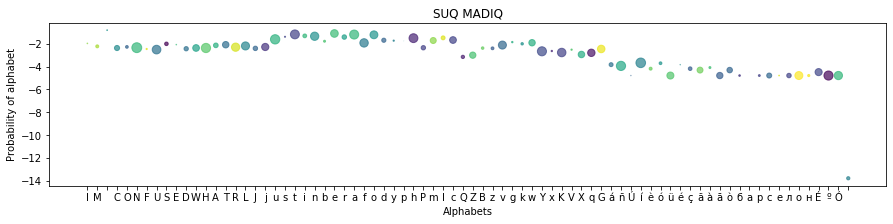

In [8]:
x = np.asarray(list(enAlphabets.values()))
x = np.append(x, (x.shape[0]))
y = enModel
print('x:\n', x)
print(enAlphabets.keys())
print('y:\n', y)

fig = plt.figure()
fig.set_size_inches(15, 3)
area = (10 * np.random.rand(x.shape[0]))**2
colors = np.random.rand(x.shape[0])
plt.title('SUQ MADIQ')
plt.xlabel('Alphabets')
plt.ylabel('Probability of alphabet')
plt.scatter(x, y, s=area, c=colors, alpha=0.7)
plt.xticks(x, list(enAlphabets.keys()))
plt.tick_params(axis='x', which='minor', labelsize=10, width = 5)